# Improved Particle Filters for Bearings-Only Tracking

This notebook provides a basic bootstrap particle filter for bearings-only tracking and its improvements.

## Why the original filter may “not track well”
With a **single fixed bearing sensor** and a **constant-velocity (CV) motion model** in Cartesian coordinates,
the system has a **scale ambiguity**:

If $(x_0, y_0, v_x, v_y)$ is consistent with the bearing measurements, then so is $k(x_0, y_0, v_x, v_y)$ for any \(k>0\),
because bearings depend on direction (angle), not distance.
So the filter can match bearings very well while the **range (distance) drifts**, making the (x,y) track look wrong.

✅ To get reliable **absolute position**, you typically need **one** of:
- **Two or more bearing sensors** (triangulation),
- A **moving sensor platform** (changing vantage point),
- An occasional **range-like cue** (even coarse),
- A **strong prior/constraint** on speed/acceleration that breaks the scale ambiguity.

This notebook includes:
- A **baseline** (bootstrap PF) with log-weights and MAP estimate,
- An improved **Auxiliary Particle Filter (APF)** with *look-ahead* weights (better proposal at resampling time),
- Optional **roughening / regularization** to reduce particle impoverishment,
- Support for **multiple sensors** (recommended).

---

**Notation:** state $z_t = [x, v_x, y, v_y]^T$. Measurement(s): bearing(s) $y_t^{(i)} = \mathrm{atan2}(y-s_y^{(i)}, x-s_x^{(i)}) + \nu$.


In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# ---------- Utilities ----------
def wrap_angle(a):
    """Wrap angles to (-pi, pi]."""
    return (a + np.pi) % (2*np.pi) - np.pi

def systematic_resample(weights, rng):
    """Systematic resampling. Returns indices."""
    N = len(weights)
    positions = (rng.random() + np.arange(N)) / N
    cumsum = np.cumsum(weights)
    idx = np.searchsorted(cumsum, positions)
    return idx

def roughen(particles, K=0.02, rng=None):
    """Gordon 'roughening' step (post-resample jitter) to reduce impoverishment."""
    if rng is None:
        rng = np.random.default_rng()
    N, d = particles.shape
    spread = particles.max(axis=0) - particles.min(axis=0)
    sigma = K * spread * (N ** (-1.0/d))
    return particles + rng.normal(0, sigma, size=particles.shape)

def logsumexp(a, axis=None):
    m = np.max(a, axis=axis, keepdims=True)
    return (m + np.log(np.sum(np.exp(a - m), axis=axis, keepdims=True))).squeeze(axis)

# ---------- Models ----------
def simulate_cv(T=160, dt=1.0, q_acc=0.2, sigma_y=0.05, sensors=((0.0,0.0),), seed=42):
    """Simulate a 2D constant-velocity target and bearing measurements from one or more sensors."""
    rng = np.random.default_rng(seed)

    F = np.array([[1, dt, 0,  0],
                  [0,  1, 0,  0],
                  [0,  0, 1, dt],
                  [0,  0, 0,  1]], dtype=float)

    Q1 = q_acc * np.array([[dt**3/3, dt**2/2],
                           [dt**2/2, dt]], dtype=float)
    Q = np.zeros((4,4))
    Q[:2,:2] = Q1
    Q[2:,2:] = Q1

    z = np.zeros((T,4))
    z[0] = np.array([20.0, 0.20, -5.0, 0.12])  # x, vx, y, vy
    for t in range(1, T):
        z[t] = F @ z[t-1] + rng.multivariate_normal(np.zeros(4), Q)

    sensors = np.array(sensors, dtype=float)  # (m,2)
    m = sensors.shape[0]
    y = np.zeros((T, m))
    for i, (sx, sy) in enumerate(sensors):
        dx = z[:,0] - sx
        dy = z[:,2] - sy
        y[:,i] = wrap_angle(np.arctan2(dy, dx) + rng.normal(0, sigma_y, size=T))

    return z, y, F, Q, sensors

def log_bearing_likelihood(y_t, states, sensors, sigma_y):
    """Log p(y_t | state) for multiple sensors (independent Gaussian bearing noise)."""
    dx = states[:,0,None] - sensors[None,:,0]
    dy = states[:,2,None] - sensors[None,:,1]
    pred = np.arctan2(dy, dx)
    err = wrap_angle(y_t[None,:] - pred)
    return np.sum(-0.5*(err/sigma_y)**2 - np.log(np.sqrt(2*np.pi)*sigma_y), axis=1)


## Baseline: Bootstrap Particle Filter (log-weights + MAP estimate)

Notes:
- Uses **log weights** for numerical stability.
- Uses **MAP** (max-weight particle) for state estimate by default; in bearings-only problems the posterior can be skewed, so MAP is often more sensible than the mean.


In [ ]:
def bootstrap_pf(y, F, Q, sensors, sigma_y, N=3000, seed=123, resample_frac=0.5, estimate='map'):
    rng = np.random.default_rng(seed)
    T, m = y.shape

    # Prior
    mu0 = np.array([15.0, 0.0, 0.0, 0.0])
    P0  = np.diag([50.0, 1.0, 50.0, 1.0])
    particles = rng.multivariate_normal(mu0, P0, size=N)

    logw = np.full(N, -np.log(N))
    est  = np.zeros((T,4))
    ESS  = np.zeros(T)

    resample_threshold = resample_frac * N

    for t in range(T):
        # Predict (bootstrap proposal = transition)
        particles = particles @ F.T + rng.multivariate_normal(np.zeros(4), Q, size=N)

        # Weight update
        logw += log_bearing_likelihood(y[t], particles, sensors, sigma_y)

        # Normalize
        logZ = logsumexp(logw)
        logw = logw - logZ
        w = np.exp(logw)

        ESS[t] = 1.0 / np.sum(w*w)

        # Estimate
        if estimate == 'map':
            est[t] = particles[np.argmax(w)]
        else:
            est[t] = np.average(particles, axis=0, weights=w)

        # Resample
        if ESS[t] < resample_threshold:
            idx = systematic_resample(w, rng)
            particles = particles[idx]
            logw = np.full(N, -np.log(N))

    return est, ESS


## Improved: Auxiliary Particle Filter (APF) + Roughening

**Main idea:** instead of resampling using weights from \(t-1\), use *look-ahead* weights that consider how likely each particle will be under the **next measurement**.

This acts like a **better proposal** (through better ancestor selection), and often improves tracking in nonlinear measurement models (like bearings).

We include an optional **roughening** step to prevent particle impoverishment when resampling frequently.


In [ ]:
def auxiliary_pf(y, F, Q, sensors, sigma_y, N=3000, seed=123, estimate='map', rough_K=0.02):
    rng = np.random.default_rng(seed)
    T, m = y.shape

    # Prior
    mu0 = np.array([15.0, 0.0, 0.0, 0.0])
    P0  = np.diag([50.0, 1.0, 50.0, 1.0])
    particles = rng.multivariate_normal(mu0, P0, size=N)
    w = np.ones(N) / N

    est = np.zeros((T,4))
    ESS = np.zeros(T)

    for t in range(T):
        # Look-ahead prediction mean for each particle (no process noise yet)
        x_bar = particles @ F.T

        # Predictive likelihood at x_bar (up to a constant)
        logp_bar = log_bearing_likelihood(y[t], x_bar, sensors, sigma_y)
        logp_bar -= np.max(logp_bar)
        p_bar = np.exp(logp_bar)  # unnormalized

        # Auxiliary weights for ancestor selection
        aux_w = w * p_bar
        aux_w /= np.sum(aux_w)

        # Resample ancestors using aux weights (this is the "better proposal" part)
        idx = systematic_resample(aux_w, rng)
        x_bar_sel = x_bar[idx]
        p_bar_sel = p_bar[idx]

        # Propagate from selected predicted means
        particles = x_bar_sel + rng.multivariate_normal(np.zeros(4), Q, size=N)

        # Optional roughening (post-resample jitter)
        if rough_K and rough_K > 0:
            particles = roughen(particles, K=rough_K, rng=rng)

        # Compute true likelihood at propagated particles
        loglik = log_bearing_likelihood(y[t], particles, sensors, sigma_y)
        loglik -= np.max(loglik)
        lik = np.exp(loglik)

        # Importance correction: w_t ∝ lik / p_bar_sel
        w = lik / (p_bar_sel + 1e-300)
        w /= np.sum(w)

        ESS[t] = 1.0 / np.sum(w*w)

        # Estimate
        if estimate == 'map':
            est[t] = particles[np.argmax(w)]
        else:
            est[t] = np.average(particles, axis=0, weights=w)

    return est, ESS


## Experiments

We compare:

1) **Single sensor** at origin — demonstrates the scale ambiguity (bearing fits well, (x,y) drifts)

2) **Two sensors** — triangulation resolves scale and tracking improves significantly




In [ ]:
def rmse_xy(est, truth):
    return np.sqrt(np.mean((est[:,[0,2]] - truth[:,[0,2]])**2))

def plot_tracks(truth, est_dict, sensors, title):
    plt.figure(figsize=(7,6))
    plt.plot(truth[:,0], truth[:,2], linewidth=2, label='True')
    for name, est in est_dict.items():
        plt.plot(est[:,0], est[:,2], label=name)
    sensors = np.array(sensors)
    plt.scatter(sensors[:,0], sensors[:,1], marker='x', s=120, label='Sensors')
    plt.xlabel('x')
    plt.ylabel('y')
    plt.title(title)
    plt.axis('equal')
    plt.grid(True)
    plt.legend()
    plt.show()

def plot_bearing_residuals(y, est, sensors, title):
    sensors = np.array(sensors)
    T, m = y.shape
    dx = est[:,0,None] - sensors[None,:,0]
    dy = est[:,2,None] - sensors[None,:,1]
    pred = np.arctan2(dy, dx)
    err = wrap_angle(y - pred)
    plt.figure(figsize=(8,3))
    for i in range(m):
        plt.plot(err[:,i], label=f'sensor {i}')
    plt.title(title)
    plt.ylabel('bearing residual (rad)')
    plt.xlabel('time')
    plt.grid(True)
    plt.legend()
    plt.show()


Single-sensor RMSE(x,y)  BPF: 24.774664436790147
Single-sensor RMSE(x,y)  APF: 23.148369661928637


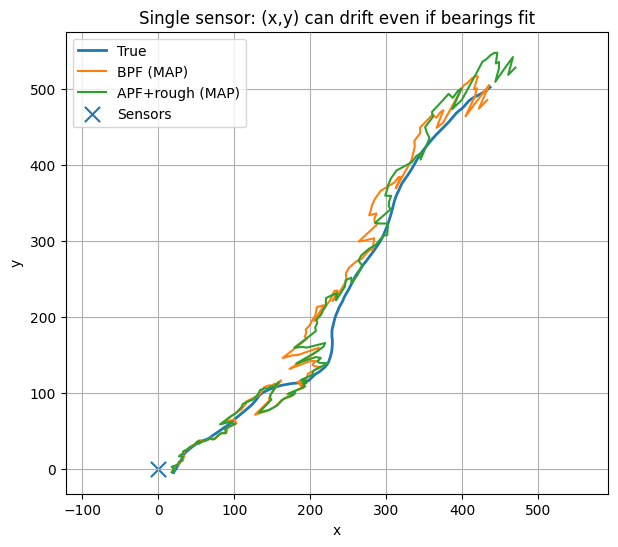

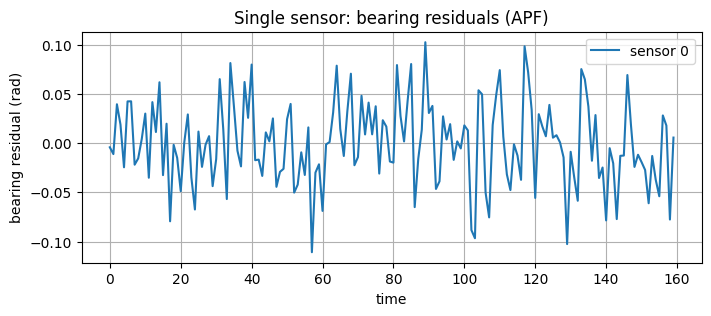

In [ ]:
# -----------------------
# Case A: Single sensor
# -----------------------
truth1, y1, F1, Q1, sensors1 = simulate_cv(sensors=((0.0,0.0),), seed=42)

est_bpf_1, ess_bpf_1 = bootstrap_pf(y1, F1, Q1, sensors1, sigma_y=0.05, N=4000, estimate='mean')
est_apf_1, ess_apf_1 = auxiliary_pf(y1, F1, Q1, sensors1, sigma_y=0.05, N=4000, estimate='mean', rough_K=0.02)

print('Single-sensor RMSE(x,y)  BPF:', rmse_xy(est_bpf_1, truth1))
print('Single-sensor RMSE(x,y)  APF:', rmse_xy(est_apf_1, truth1))

plot_tracks(truth1, {'BPF (MAP)': est_bpf_1, 'APF+rough (MAP)': est_apf_1}, sensors1,
            title='Single sensor: (x,y) can drift even if bearings fit')

plot_bearing_residuals(y1, est_apf_1, sensors1, title='Single sensor: bearing residuals (APF)')


Two-sensor RMSE(x,y)  BPF: 77.25790334703052
Two-sensor RMSE(x,y)  APF: 62.5198057291442


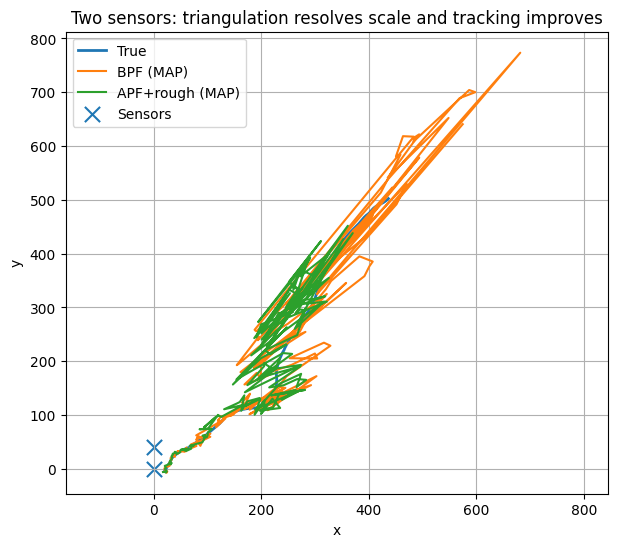

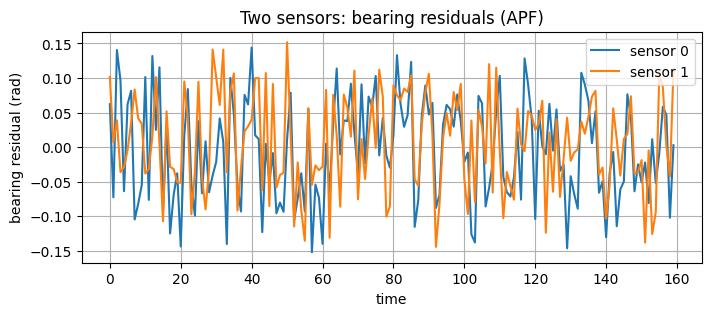

In [ ]:
# -----------------------
# Case B: Two sensors
# -----------------------
truth2, y2, F2, Q2, sensors2 = simulate_cv(sensors=((0.0,0.0),(0.0,40.0)), seed=42)

est_bpf_2, ess_bpf_2 = bootstrap_pf(y2, F2, Q2, sensors2, sigma_y=0.05, N=2500, estimate='map')
est_apf_2, ess_apf_2 = auxiliary_pf(y2, F2, Q2, sensors2, sigma_y=0.05, N=2500, estimate='map', rough_K=0.02)

print('Two-sensor RMSE(x,y)  BPF:', rmse_xy(est_bpf_2, truth2))
print('Two-sensor RMSE(x,y)  APF:', rmse_xy(est_apf_2, truth2))

plot_tracks(truth2, {'BPF (MAP)': est_bpf_2, 'APF+rough (MAP)': est_apf_2}, sensors2,
            title='Two sensors: triangulation resolves scale and tracking improves')

plot_bearing_residuals(y2, est_apf_2, sensors2, title='Two sensors: bearing residuals (APF)')


## Quick covariance tuning helpers

### Estimate measurement noise (sigma_y) from residuals
A simple (often effective) approach is:
1) Run the filter with a reasonable initial guess
2) Compute bearing residuals
3) Set `sigma_y_hat` using a robust scale estimate (MAD)

### Grid-search q_acc (process noise)
If you have ground truth (simulation) you can grid-search `q_acc`.
If you don't, you can still grid-search using the **average log-likelihood** as a proxy.


In [ ]:
def robust_sigma_from_residuals(residuals):
    """Robust sigma via MAD. residuals shape (T,m)."""
    r = residuals.reshape(-1)
    med = np.median(r)
    mad = np.median(np.abs(r - med))
    return 1.4826 * mad  # approx sigma for Gaussian

def bearing_residuals(y, est, sensors):
    sensors = np.array(sensors)
    dx = est[:,0,None] - sensors[None,:,0]
    dy = est[:,2,None] - sensors[None,:,1]
    pred = np.arctan2(dy, dx)
    return wrap_angle(y - pred)

# Example: estimate sigma_y from APF residuals in the 2-sensor case
res2 = bearing_residuals(y2, est_apf_2, sensors2)
sigma_y_hat = robust_sigma_from_residuals(res2)
print('Robust sigma_y_hat (rad) from APF residuals:', sigma_y_hat)

# Example: coarse grid search for q_acc (requires truth here; remove if real data)
q_grid = np.logspace(-3, 0, 8)  # 1e-3 ... 1
rmse_grid = []
for q in q_grid:
    truth_tmp, y_tmp, F_tmp, Q_tmp, sensors_tmp = simulate_cv(q_acc=float(q), sensors=((0.0,0.0),(0.0,40.0)), seed=42)
    est_tmp, _ = auxiliary_pf(y_tmp, F_tmp, Q_tmp, sensors_tmp, sigma_y=0.05, N=2000, estimate='mean', rough_K=0.02)
    rmse_grid.append(rmse_xy(est_tmp, truth_tmp))
best = int(np.argmin(rmse_grid))
print('q_acc grid:', q_grid)
print('rmse grid:', rmse_grid)
print('best q_acc (by RMSE in this sim):', q_grid[best])


Robust sigma_y_hat (rad) from APF residuals: 0.08418738088876333
q_acc grid: [0.001      0.0026827  0.00719686 0.01930698 0.05179475 0.13894955
 0.37275937 1.        ]
rmse grid: [np.float64(1.3949562284674317), np.float64(1.721964233852607), np.float64(2.6050235656867224), np.float64(5.503258552814755), np.float64(8.903368957862257), np.float64(18.131071558019457), np.float64(31.24873729047786), np.float64(45.474680948489784)]
best q_acc (by RMSE in this sim): 0.001


## Practical tuning tips (what to change first)

1) **Use MAP estimate** for (x,y) if the posterior is skewed/multimodal  
2) **Increase particle count** (N) until the ESS curve looks reasonable  
3) Tune **q_acc** (process noise):
   - Too small → filter can’t follow maneuvers  
   - Too large → particles spread too much, weights collapse  
4) Tune **sigma_y** (measurement noise):
   - Too small → likelihood too peaky → degeneracy  
   - Too large → weak correction → drift  
5) For APF:
   - `rough_K ≈ 0.01–0.05` is a good start

---

## What if you truly only have one bearing sensor?

Then you cannot reliably recover absolute range without *extra information*.

If you tell me what extra cue you have (even a weak one—e.g., occasional range, speed limits, platform motion), I can
add it as an extra likelihood term or as part of the proposal.


## Particle-cloud visualization (distribution over time)

The following cells add **particle history logging** and **snapshot plots** to visualize how the particle cloud evolves.
This is especially useful for **bearings-only** problems (where the posterior can be long, curved, or multimodal).

Notes:
- `store_every=1` stores every time step (more memory). Use `store_every=2,5,10` to thin.
- The snapshot plot draws the particle cloud in $(s_x,s_y)$ at selected time indices.

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

def bootstrap_pf_with_history(y, F, Q, sensors, sigma_y, N=3000, seed=123, resample_frac=0.5,
                             estimate='map', store_every=1, store_full_state=True):
    # Bootstrap PF but returns particle/weight history for visualization.
    #
    # Returns:
    #   est: (T,4)
    #   ESS: (T,)
    #   hist: dict with keys 't', 'particles', 'weights'
    #         - particles[k] is (N,4) or (N,2) depending on store_full_state
    #         - weights[k] is (N,)
    #         - t[k] is the corresponding time index
    rng = np.random.default_rng(seed)
    T, m = y.shape
    sensors = np.array(sensors, dtype=float)

    # Prior (same as main notebook)
    mu0 = np.array([15.0, 0.0, 0.0, 0.0])
    P0  = np.diag([50.0, 1.0, 50.0, 1.0])
    particles = rng.multivariate_normal(mu0, P0, size=N)

    logw = np.full(N, -np.log(N))
    est  = np.zeros((T,4))
    ESS  = np.zeros(T)

    resample_threshold = resample_frac * N

    hist_t = []
    hist_particles = []
    hist_weights = []

    for t in range(T):
        # Propagate
        particles = particles @ F.T + rng.multivariate_normal(np.zeros(4), Q, size=N)

        # Weight update in log domain
        loglik = log_bearing_likelihood(y[t], particles, sensors, sigma_y)
        logw = logw + loglik
        logw = logw - logsumexp(logw)  # normalize
        w = np.exp(logw)

        ESS[t] = 1.0 / np.sum(w*w)

        # Estimate
        if estimate == 'map':
            est[t] = particles[np.argmax(w)]
        else:
            est[t] = np.average(particles, axis=0, weights=w)

        # Store history (after update, before optional resample)
        if (t % store_every) == 0:
            hist_t.append(t)
            if store_full_state:
                hist_particles.append(particles.astype(np.float32, copy=True))
            else:
                hist_particles.append(particles[:, [0,2]].astype(np.float32, copy=True))
            hist_weights.append(w.astype(np.float32, copy=True))

        # Resample if needed
        if ESS[t] < resample_threshold:
            idx = systematic_resample(w, rng)
            particles = particles[idx]
            logw = np.full(N, -np.log(N))

    hist = {"t": np.array(hist_t, dtype=int), "particles": hist_particles, "weights": hist_weights}
    return est, ESS, hist


def auxiliary_pf_with_history(y, F, Q, sensors, sigma_y, N=3000, seed=123, estimate='map',
                              rough_K=0.02, store_every=1, store_full_state=True):
    # Auxiliary PF (look-ahead ancestor selection) with history for visualization.
    rng = np.random.default_rng(seed)
    T, m = y.shape
    sensors = np.array(sensors, dtype=float)

    # Prior (same as main notebook)
    mu0 = np.array([15.0, 0.0, 0.0, 0.0])
    P0  = np.diag([50.0, 1.0, 50.0, 1.0])
    particles = rng.multivariate_normal(mu0, P0, size=N)
    w = np.ones(N) / N

    est = np.zeros((T,4))
    ESS = np.zeros(T)

    hist_t = []
    hist_particles = []
    hist_weights = []

    for t in range(T):
        # Look-ahead prediction mean (no process noise yet)
        x_bar = particles @ F.T

        # Predictive likelihood for ancestor selection
        loglik_bar = log_bearing_likelihood(y[t], x_bar, sensors, sigma_y)
        log_pbar = np.log(w + 1e-300) + loglik_bar
        log_pbar -= logsumexp(log_pbar)
        pbar = np.exp(log_pbar)

        # Resample ancestors according to pbar
        idx = systematic_resample(pbar, rng)
        particles_a = particles[idx]
        pbar_sel = pbar[idx]

        # Propagate with process noise
        particles = particles_a @ F.T + rng.multivariate_normal(np.zeros(4), Q, size=N)

        # Compute likelihood
        loglik = log_bearing_likelihood(y[t], particles, sensors, sigma_y)
        lik = np.exp(loglik - np.max(loglik))  # stabilized positive weights

        # Importance correction: w_t ∝ lik / pbar_sel
        w = lik / (pbar_sel + 1e-300)
        w /= np.sum(w)

        # Roughening to avoid impoverishment (optional but helpful)
        particles = roughen(particles, K=rough_K, rng=rng)

        ESS[t] = 1.0 / np.sum(w*w)

        # Estimate
        if estimate == 'map':
            est[t] = particles[np.argmax(w)]
        else:
            est[t] = np.average(particles, axis=0, weights=w)

        # Store history
        if (t % store_every) == 0:
            hist_t.append(t)
            if store_full_state:
                hist_particles.append(particles.astype(np.float32, copy=True))
            else:
                hist_particles.append(particles[:, [0,2]].astype(np.float32, copy=True))
            hist_weights.append(w.astype(np.float32, copy=True))

    hist = {"t": np.array(hist_t, dtype=int), "particles": hist_particles, "weights": hist_weights}
    return est, ESS, hist

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

def _ray_segment_from_sensor(sx, sy, theta, length=200.0):
    # Line segment for a bearing ray from (sx,sy) at angle theta.
    x2 = sx + length*np.cos(theta)
    y2 = sy + length*np.sin(theta)
    return (sx, x2), (sy, y2)

def plot_particle_snapshots_xy(hist, truth, est, sensors, y=None, steps=None,
                               title='Particle snapshots', max_cols=4,
                               s=3, alpha=0.08, show_weights=False,
                               savepath=None):
    # Grid of particle cloud snapshots in (s_x, s_y) at selected steps.
    sensors = np.array(sensors, dtype=float)
    T = truth.shape[0]

    if steps is None:
        steps = np.unique(np.linspace(0, T-1, 8, dtype=int)).tolist()

    # Map desired steps -> closest stored indices in hist
    t_hist = hist["t"]
    chosen = []
    for t in steps:
        j = int(np.argmin(np.abs(t_hist - t)))
        chosen.append(j)

    n = len(chosen)
    cols = min(max_cols, n)
    rows = int(np.ceil(n / cols))

    fig, axs = plt.subplots(rows, cols, figsize=(3.6*cols, 3.4*rows), sharex=True, sharey=True)
    axs = np.array(axs).reshape(-1)

    # Limits from truth for consistent framing
    xmin, xmax = np.min(truth[:,0]), np.max(truth[:,0])
    ymin, ymax = np.min(truth[:,2]), np.max(truth[:,2])
    pad_x = 0.15*(xmax-xmin + 1e-9)
    pad_y = 0.15*(ymax-ymin + 1e-9)

    for k, ax in enumerate(axs):
        if k >= n:
            ax.axis("off")
            continue

        j = chosen[k]
        t = int(t_hist[j])
        P = hist["particles"][j]
        W = hist["weights"][j]

        # Support both full-state and (x,y)-only storage
        if P.shape[1] == 4:
            px, py = P[:,0], P[:,2]
        else:
            px, py = P[:,0], P[:,1]

        if show_weights:
            # Use weights to modulate alpha (no colormap)
            ww = W / (np.max(W) + 1e-12)
            ax.scatter(px, py, s=s, alpha=np.clip(alpha*(0.2 + 0.8*ww), 0.01, 0.4))
        else:
            ax.scatter(px, py, s=s, alpha=alpha)

        # True + estimated prefix track
        ax.plot(truth[:t+1,0], truth[:t+1,2], 'k-', lw=1)
        ax.plot(est[:t+1,0], est[:t+1,2], 'r--', lw=1)

        # Current true/est point
        ax.scatter([truth[t,0]], [truth[t,2]], marker='x', s=45, c='k')
        ax.scatter([est[t,0]], [est[t,2]], marker='o', s=25, c='r')

        # Sensors
        ax.scatter(sensors[:,0], sensors[:,1], s=45)

        # Bearing rays (optional)
        if y is not None:
            for i in range(sensors.shape[0]):
                xs, ys = sensors[i]
                theta = float(y[t,i])
                xr, yr = _ray_segment_from_sensor(xs, ys, theta,
                                                 length=max(xmax-xmin, ymax-ymin) + 80.0)
                ax.plot(xr, yr, lw=1, alpha=0.6)

        ax.set_title(f"t = {t}")
        ax.set_xlim(xmin - pad_x, xmax + pad_x)
        ax.set_ylim(ymin - pad_y, ymax + pad_y)
        ax.set_aspect("equal", adjustable="box")

    fig.suptitle(title)
    fig.supxlabel("$s_x$")
    fig.supylabel("$s_y$")
    fig.tight_layout()

    if savepath is not None:
        fig.savefig(savepath, dpi=180, bbox_inches="tight")
    plt.show()


def plot_one_sensor_style_panels(truth, est, ESS, y, sensors, filter_type='pf', sigma_y_true=None,
                                 win=25, save_prefix=None):
    # Replicates your style:
    #   - track plot
    #   - 4x1 time series: sx, sy, sigma_hat (rolling MAD), ESS
    sx_true = truth[:,0]
    sy_true = truth[:,2]
    sensors = np.array(sensors, dtype=float)

    # Track plot
    fig, ax = plt.subplots(figsize=(7,6))
    ax.plot(sx_true, sy_true, 'k-', lw=2, label='true')
    ax.plot(est[:,0], est[:,2], 'r--', lw=2, label=f'{filter_type.upper()} PF')
    ax.scatter([sensors[0,0]],[sensors[0,1]], s=70, label='sensor')
    ax.axis('equal')
    ax.set_xlabel('$s_x$'); ax.set_ylabel('$s_y$')
    ax.set_title('One-sensor bearings-only tracking')
    ax.legend(fontsize=9)
    fig.tight_layout()
    if save_prefix is not None:
        fig.savefig(f'{save_prefix}_track.png', dpi=180, bbox_inches='tight')
    plt.show()

    # Rolling robust sigma estimate from residuals
    res = bearing_residuals(y, est, sensors)  # (T,m)
    sigma2_est = np.zeros(len(res))
    for t in range(len(res)):
        a = max(0, t-win+1)
        sigma_hat = robust_sigma_from_residuals(res[a:t+1])
        sigma2_est[t] = sigma_hat**2

    fig, axs = plt.subplots(4,1, figsize=(9,10), sharex=True)
    axs[0].plot(sx_true, 'k-', label='true')
    axs[0].plot(est[:,0], 'r--', label='PF')
    axs[0].set_ylabel('$s_x$'); axs[0].legend(fontsize=8)

    axs[1].plot(sy_true, 'k-')
    axs[1].plot(est[:,2], 'r--')
    axs[1].set_ylabel('$s_y$')

    axs[2].plot(np.sqrt(sigma2_est), lw=2)
    if sigma_y_true is not None:
        axs[2].axhline(sigma_y_true, color='k', ls='--', lw=1)
    axs[2].set_ylabel(r'$\hat\sigma_y$')
    axs[2].set_title('Online (rolling) estimate of bearing noise (robust MAD)')

    axs[3].plot(ESS, lw=2)
    axs[3].set_ylabel('ESS')
    axs[3].set_xlabel('time $t$')
    axs[3].set_title('Effective sample size')

    fig.tight_layout()
    if save_prefix is not None:
        fig.savefig(f'{save_prefix}_timeseries_sigma_ess.png', dpi=180, bbox_inches='tight')
    plt.show()

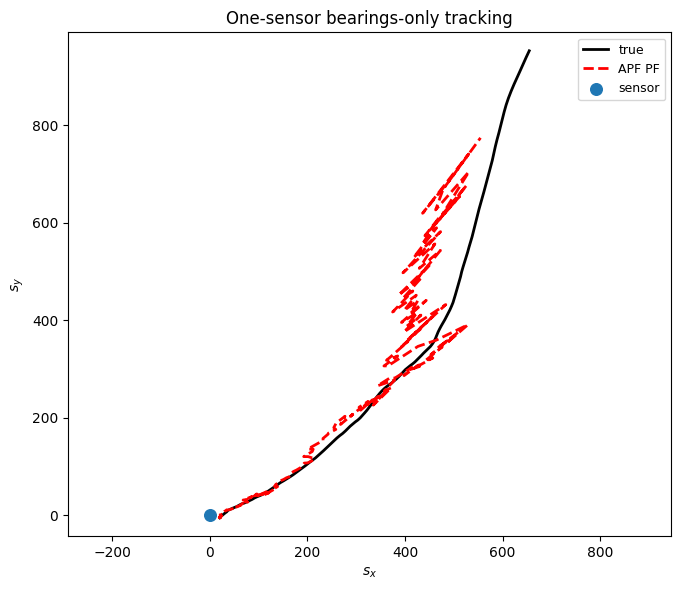

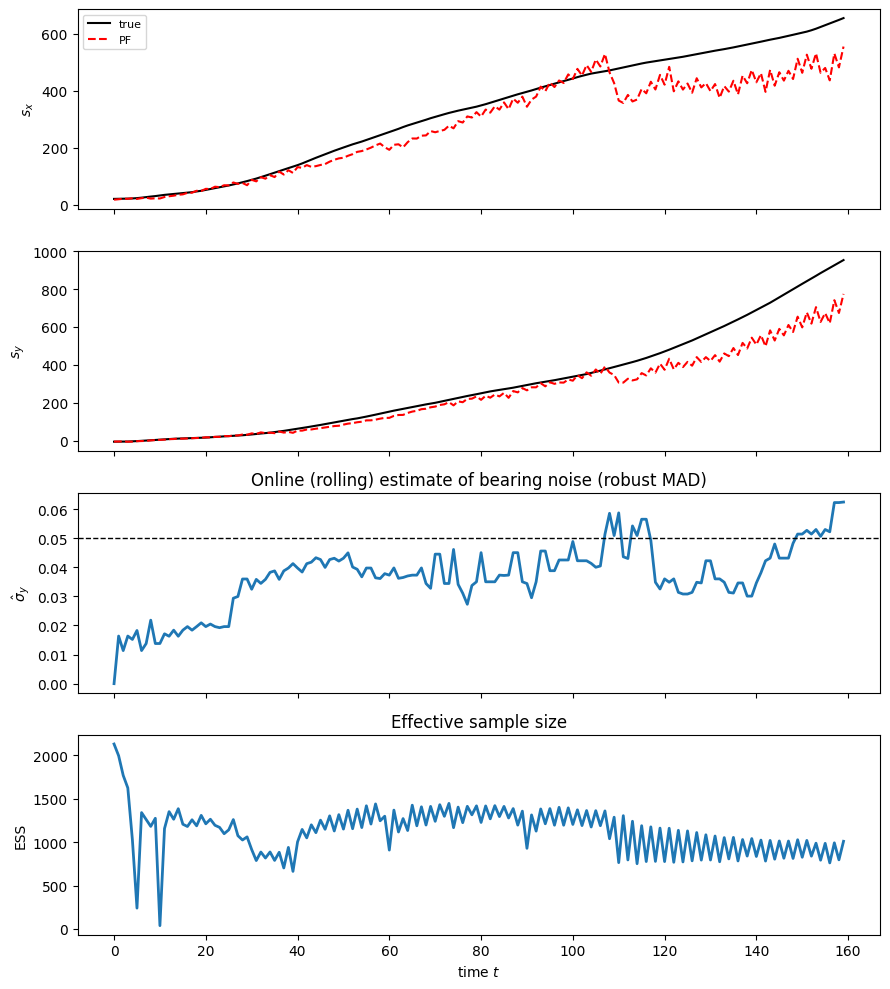

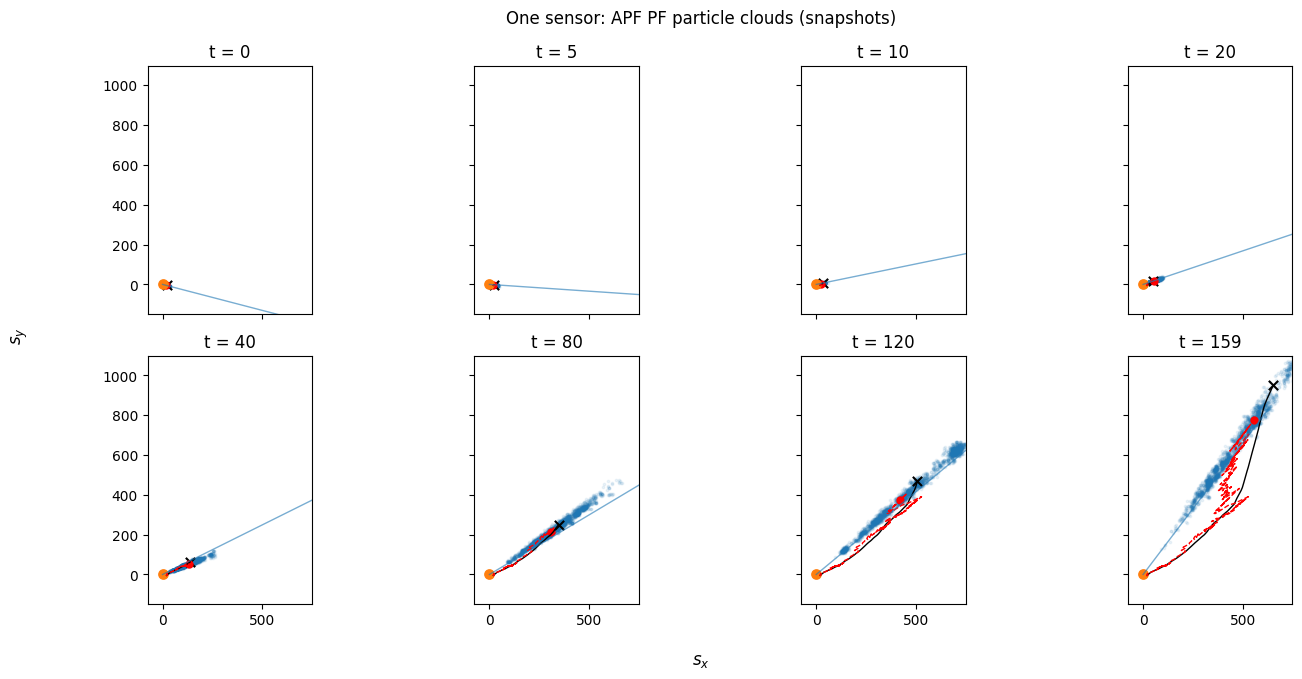

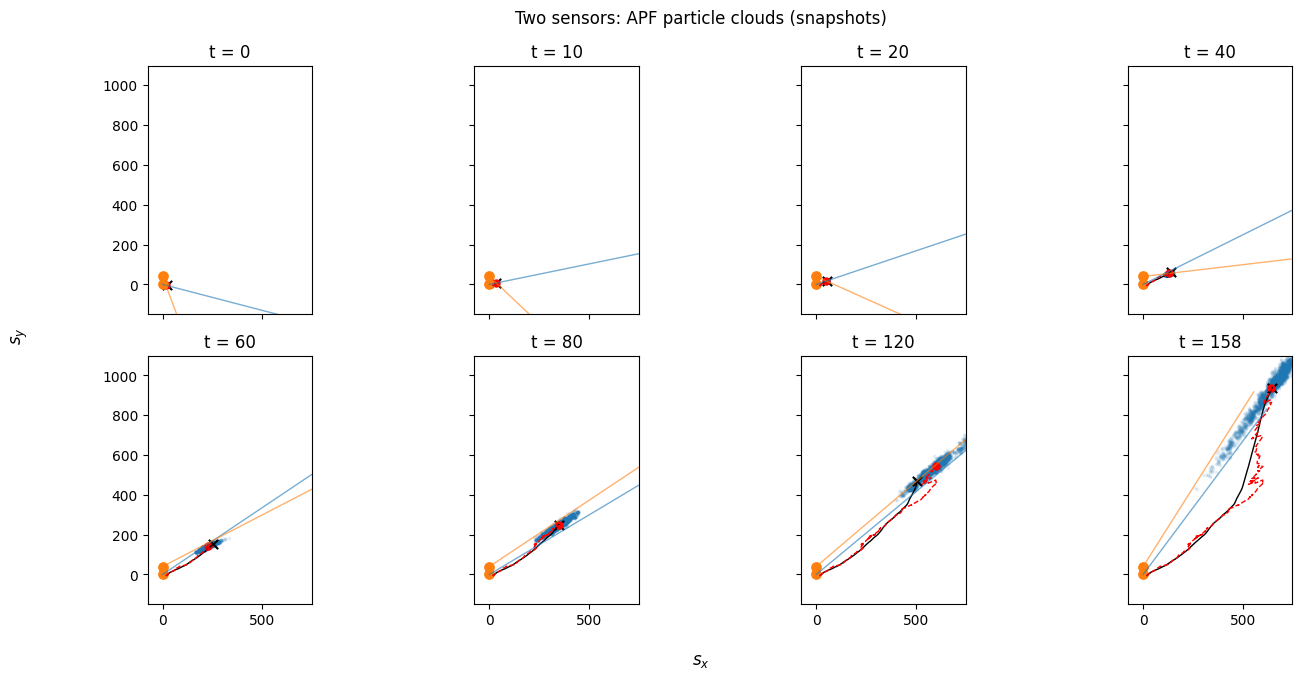

In [ ]:
# -----------------------
# Demo: one-sensor case + particle snapshots
# -----------------------
sigma_y_true = 0.05
truth1, y1, F1, Q1, sensors1 = simulate_cv(sensors=((0.0,0.0),), sigma_y=sigma_y_true, seed=7)

filter_type = "apf"  # "bpf" or "apf"
if filter_type == "bpf":
    est1, ESS1, hist1 = bootstrap_pf_with_history(y1, F1, Q1, sensors1, sigma_y=sigma_y_true,
                                                  N=2500, seed=7, estimate='mean',
                                                  store_every=1, store_full_state=False)
else:
    est1, ESS1, hist1 = auxiliary_pf_with_history(y1, F1, Q1, sensors1, sigma_y=sigma_y_true,
                                                  N=2500, seed=7, estimate='mean', rough_K=0.02,
                                                  store_every=1, store_full_state=False)

# Replicate your "style" panels
plot_one_sensor_style_panels(truth1, est1, ESS1, y1, sensors1,
                             filter_type=filter_type, sigma_y_true=sigma_y_true,
                             save_prefix=None)

# Particle cloud snapshots (choose any steps you like)
steps = [0, 5, 10, 20, 40, 80, 120, 159]
plot_particle_snapshots_xy(hist1, truth1, est1, sensors1, y=y1, steps=steps,
                           title=f"One sensor: {filter_type.upper()} PF particle clouds (snapshots)",
                           show_weights=False, savepath=None)


# -----------------------
# Demo: two-sensor case (optional) + particle snapshots
# -----------------------
truth2, y2, F2, Q2, sensors2 = simulate_cv(sensors=((0.0,0.0),(0.0,40.0)), sigma_y=sigma_y_true, seed=7)

est2, ESS2, hist2 = auxiliary_pf_with_history(y2, F2, Q2, sensors2, sigma_y=sigma_y_true,
                                              N=2500, seed=7, estimate='mean', rough_K=0.02,
                                              store_every=2, store_full_state=False)

steps2 = [0, 10, 20, 40, 60, 80, 120, 159]
plot_particle_snapshots_xy(hist2, truth2, est2, sensors2, y=y2, steps=steps2,
                           title="Two sensors: APF particle clouds (snapshots)",
                           show_weights=False, savepath=None)

## MP4 animation of particle cloud over time

This section creates an **MP4 animation** of the particle cloud evolving over time.
It works with `hist` returned by `bootstrap_pf_with_history(...)` or `auxiliary_pf_with_history(...)`.

Tips for good-looking / stable animations:
- Use `store_every=2` or `store_every=5` when running the PF to reduce frames and file size.
- Use `max_points` to subsample particles for visualization (the filter still uses all particles).

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import animation

def make_particle_animation_mp4(hist, truth, est, sensors, y=None,
                                outfile="particle_cloud.mp4",
                                fps=20, dpi=160, max_points=1500,
                                trail=True, trail_len=200,
                                show_bearing_rays=True,
                                ray_length=250.0,
                                title="Particle cloud animation"):
    """
    Create an MP4 animation showing particle cloud + truth/estimate over time.

    Args:
      hist: dict with keys 't', 'particles', 'weights'
      truth: (T,4) true states
      est: (T,4) estimated states
      sensors: (m,2)
      y: (T,m) bearings (optional)
    """
    sensors = np.array(sensors, dtype=float)
    t_hist = hist["t"]
    P0 = hist["particles"][0]
    N = P0.shape[0]

    # Choose a fixed subset of particles to plot (for speed / smaller MP4)
    rng = np.random.default_rng(0)
    if (max_points is None) or (max_points >= N):
        plot_idx = np.arange(N)
    else:
        plot_idx = rng.choice(N, size=max_points, replace=False)

    # Axis limits from truth (with padding)
    xmin, xmax = np.min(truth[:,0]), np.max(truth[:,0])
    ymin, ymax = np.min(truth[:,2]), np.max(truth[:,2])
    pad_x = 0.25*(xmax-xmin + 1e-9)
    pad_y = 0.25*(ymax-ymin + 1e-9)

    fig, ax = plt.subplots(figsize=(7.2, 6.2))
    ax.set_xlim(xmin - pad_x, xmax + pad_x)
    ax.set_ylim(ymin - pad_y, ymax + pad_y)
    ax.set_aspect("equal", adjustable="box")
    ax.set_xlabel("$s_x$")
    ax.set_ylabel("$s_y$")
    ax.set_title(title)

    # Static: sensors
    ax.scatter(sensors[:,0], sensors[:,1], s=80, label="sensor")

    # Dynamic artists
    scat = ax.scatter([], [], s=6, alpha=0.10)
    truth_line, = ax.plot([], [], "k-", lw=2, label="true")
    est_line,   = ax.plot([], [], "r--", lw=2, label="PF")
    truth_pt = ax.scatter([], [], marker="x", s=70)
    est_pt   = ax.scatter([], [], marker="o", s=40)
    time_text = ax.text(0.02, 0.98, "", transform=ax.transAxes, va="top", ha="left")

    ray_lines = []
    if (y is not None) and show_bearing_rays:
        for _ in range(sensors.shape[0]):
            ln, = ax.plot([], [], lw=1, alpha=0.5)
            ray_lines.append(ln)

    ax.legend(fontsize=9, loc="lower right")

    def _get_xy(P):
        # Support both full-state (N,4) and xy-only (N,2)
        if P.shape[1] == 4:
            return P[:,0], P[:,2]
        else:
            return P[:,0], P[:,1]

    def init():
        scat.set_offsets(np.zeros((1,2)))
        truth_line.set_data([], [])
        est_line.set_data([], [])
        truth_pt.set_offsets(np.zeros((1,2)))
        est_pt.set_offsets(np.zeros((1,2)))
        time_text.set_text("")
        for ln in ray_lines:
            ln.set_data([], [])
        return (scat, truth_line, est_line, truth_pt, est_pt, time_text, *ray_lines)

    def update(frame_idx):
        t = int(t_hist[frame_idx])
        P = hist["particles"][frame_idx]

        px, py = _get_xy(P)
        px = px[plot_idx]
        py = py[plot_idx]
        scat.set_offsets(np.c_[px, py])

        if trail:
            a = max(0, t - trail_len)
            truth_line.set_data(truth[a:t+1,0], truth[a:t+1,2])
            est_line.set_data(est[a:t+1,0], est[a:t+1,2])
        else:
            truth_line.set_data(truth[:t+1,0], truth[:t+1,2])
            est_line.set_data(est[:t+1,0], est[:t+1,2])

        truth_pt.set_offsets(np.array([[truth[t,0], truth[t,2]]]))
        est_pt.set_offsets(np.array([[est[t,0], est[t,2]]]))

        time_text.set_text(f"t = {t}")

        if (y is not None) and show_bearing_rays:
            for i, (sx, sy) in enumerate(sensors):
                theta = float(y[t, i])
                x2 = sx + ray_length*np.cos(theta)
                y2 = sy + ray_length*np.sin(theta)
                ray_lines[i].set_data([sx, x2], [sy, y2])

        return (scat, truth_line, est_line, truth_pt, est_pt, time_text, *ray_lines)

    anim = animation.FuncAnimation(fig, update, frames=len(t_hist),
                                   init_func=init, blit=True, interval=1000/fps)

    writer = animation.FFMpegWriter(fps=fps, bitrate=1800)
    anim.save(outfile, writer=writer, dpi=dpi)
    plt.close(fig)
    print(f"Saved MP4 -> {outfile}")
    return outfile

## Noise tuning and preventing cloud explosion

If the particle cloud grows without bound, it's almost always one (or a mix) of these:
1. Process noise too large (Q too large): particles wander far and the cloud expands.
2. Measurement noise too large (sigma_y too large): bearings are treated as weak evidence, so the filter does not pull particles back.
3. Bearings-only geometry: a single stationary bearing sensor cannot fully localize range; the posterior tends to be long and thin.

Practical fixes in this notebook:
- Choose Q from physical bounds (max acceleration / max speed).
- Enforce constraints (penalize or clip particles that violate speed limits).
- Use Liu-West shrinkage after resampling (prevents variance from constantly inflating).
- Optional: mixture process noise (mostly small diffusion, occasional maneuver).

In [ ]:
import numpy as np

def make_Q_cv_from_sigma_a(dt, sigma_a):
    """
    Constant-velocity (CV) model with white acceleration noise of std sigma_a (m/s^2).
    State: [sx, vx, sy, vy].
    """
    q = sigma_a**2
    Q1 = q * np.array([[dt**4/4, dt**3/2],
                       [dt**3/2, dt**2]])
    Q = np.zeros((4,4))
    Q[0:2, 0:2] = Q1
    Q[2:4, 2:4] = Q1
    return Q

def sigma_a_from_a_max(a_max):
    # Rule of thumb: 3-sigma bound -> a_max ~= 3*sigma_a
    return a_max / 5.0

def clip_speed(states, v_max):
    x = states.copy()
    vx = x[:,1]
    vy = x[:,3]
    sp = np.sqrt(vx*vx + vy*vy) + 1e-12
    mask = sp > v_max
    scale = v_max / sp[mask]
    vx[mask] *= scale
    vy[mask] *= scale
    x[:,1] = vx
    x[:,3] = vy
    return x

def soft_speed_logprior(states, v_max, sigma_soft=0.25):
    vx = states[:,1]
    vy = states[:,3]
    sp = np.sqrt(vx*vx + vy*vy)
    excess = np.maximum(0.0, sp - v_max)
    return -0.5*(excess/sigma_soft)**2

def liu_west_shrink(particles, h=0.08, rng=None):
    """
    Liu-West kernel shrinkage: combats impoverishment while keeping variance controlled.
    h in (0,1). Smaller h = more shrinkage and less random spread.
    """
    if rng is None:
        rng = np.random.default_rng()
    N, d = particles.shape
    mu = np.mean(particles, axis=0)
    cov = np.cov(particles.T) + 1e-9*np.eye(d)
    a = np.sqrt(1 - h*h)
    jitter = rng.multivariate_normal(np.zeros(d), (h*h)*cov, size=N)
    return a*particles + (1-a)*mu + jitter

def mixture_accel_noise(rng, N, Q_small, Q_big, p_big=0.05):
    choose_big = rng.random(N) < p_big
    noise = np.zeros((N,4))
    n_small = np.sum(~choose_big)
    n_big   = np.sum(choose_big)
    if n_small > 0:
        noise[~choose_big] = rng.multivariate_normal(np.zeros(4), Q_small, size=n_small)
    if n_big > 0:
        noise[choose_big] = rng.multivariate_normal(np.zeros(4), Q_big, size=n_big)
    return noise

def auxiliary_pf_constrained_with_history(y, F, Q, sensors, sigma_y, N=3000, seed=123, estimate='map',
                                         rejuvenation="liu_west", h=0.08, rough_K=0.01,
                                         v_max=None, soft_vprior=False, vprior_soft=0.25,
                                         mixture_process=False, Q_big=None, p_big=0.05,
                                         store_every=2, store_full_state=False):
    rng = np.random.default_rng(seed)
    T, m = y.shape
    sensors = np.array(sensors, dtype=float)

    # Prior
    mu0 = np.array([15.0, 0.0, 0.0, 0.0])
    P0  = np.diag([50.0, 1.0, 50.0, 1.0])
    particles = rng.multivariate_normal(mu0, P0, size=N)
    w = np.ones(N) / N

    est = np.zeros((T,4))
    ESS = np.zeros(T)

    hist_t, hist_particles, hist_weights = [], [], []

    for t in range(T):
        # Look-ahead mean (no noise) for ancestor selection
        x_bar = particles @ F.T
        loglik_bar = log_bearing_likelihood(y[t], x_bar, sensors, sigma_y)
        if soft_vprior and (v_max is not None):
            loglik_bar = loglik_bar + soft_speed_logprior(x_bar, v_max, sigma_soft=vprior_soft)

        log_pbar = np.log(w + 1e-300) + loglik_bar
        log_pbar -= logsumexp(log_pbar)
        pbar = np.exp(log_pbar)

        idx = systematic_resample(pbar, rng)
        particles_a = particles[idx]
        pbar_sel = pbar[idx]

        # Propagate
        if mixture_process:
            assert Q_big is not None, "Provide Q_big when mixture_process=True"
            noise = mixture_accel_noise(rng, N, Q, Q_big, p_big=p_big)
            particles = particles_a @ F.T + noise
        else:
            particles = particles_a @ F.T + rng.multivariate_normal(np.zeros(4), Q, size=N)

        # Speed constraint
        if (v_max is not None) and (not soft_vprior):
            particles = clip_speed(particles, v_max)

        # Likelihood (+ optional soft prior)
        loglik = log_bearing_likelihood(y[t], particles, sensors, sigma_y)
        if soft_vprior and (v_max is not None):
            loglik = loglik + soft_speed_logprior(particles, v_max, sigma_soft=vprior_soft)

        lik = np.exp(loglik - np.max(loglik))
        w = lik / (pbar_sel + 1e-300)
        w /= np.sum(w)

        # Rejuvenation / variance control
        if rejuvenation.lower() == "liu_west":
            particles = liu_west_shrink(particles, h=h, rng=rng)
        else:
            particles = roughen(particles, K=rough_K, rng=rng)

        ESS[t] = 1.0 / np.sum(w*w)

        # Estimate
        if estimate == "map":
            est[t] = particles[np.argmax(w)]
        else:
            est[t] = np.average(particles, axis=0, weights=w)

        # Store history
        if (t % store_every) == 0:
            hist_t.append(t)
            if store_full_state:
                hist_particles.append(particles.astype(np.float32, copy=True))
            else:
                hist_particles.append(particles[:, [0,2]].astype(np.float32, copy=True))
            hist_weights.append(w.astype(np.float32, copy=True))

    hist = {"t": np.array(hist_t, dtype=int), "particles": hist_particles, "weights": hist_weights}
    return est, ESS, hist

In [ ]:
# -----------------------
# Demo: generate MP4 files
# -----------------------
sigma_y_true = 0.05
dt = 1.0

# Pick local motion by bounding acceleration.
# For a "3-sigma" bound a_max ~= 3*sigma_a, set sigma_a = a_max/3 and use q_acc = sigma_a^2 as a scale.
a_max = 0.25          # max accel (m/s^2) -- decrease to prevent big jumps
sigma_a = sigma_a_from_a_max(a_max)
q_acc  = sigma_a**2   # scale for the simulate_cv() process noise

# Optional speed limit
v_max = 1.8  # m/s

# One sensor
truth1, y1, F1, Q1, sensors1 = simulate_cv(sensors=((0.0,0.0),), sigma_y=sigma_y_true, seed=7, dt=dt, q_acc=q_acc)
est1, ESS1, hist1 = auxiliary_pf_constrained_with_history(
    y1, F1, Q1, sensors1, sigma_y=sigma_y_true,
    N=3000, seed=7, estimate="mean",
    rejuvenation="liu_west", h=0.08,
    v_max=v_max, soft_vprior=False,
    store_every=2, store_full_state=False
)

mp4_1 = make_particle_animation_mp4(
    hist1, truth1, est1, sensors1, y=y1,
    outfile="anim_one_sensor_apf.mp4",
    fps=20, dpi=160, max_points=1400,
    trail=True, trail_len=180,
    show_bearing_rays=True, ray_length=260.0,
    title="One sensor: APF constrained + Liu-West"
)
mp4_1

# Two sensors (recommended)
truth2, y2, F2, Q2, sensors2 = simulate_cv(sensors=((0.0,0.0),(0.0,40.0)), sigma_y=sigma_y_true, seed=7, dt=dt, q_acc=q_acc)
est2, ESS2, hist2 = auxiliary_pf_constrained_with_history(
    y2, F2, Q2, sensors2, sigma_y=sigma_y_true,
    N=3000, seed=7, estimate="mean",
    rejuvenation="liu_west", h=0.08,
    v_max=v_max, soft_vprior=False,
    store_every=2, store_full_state=False
)

mp4_2 = make_particle_animation_mp4(
    hist2, truth2, est2, sensors2, y=y2,
    outfile="anim_two_sensor_apf.mp4",
    fps=20, dpi=160, max_points=1400,
    trail=True, trail_len=180,
    show_bearing_rays=True, ray_length=260.0,
    title="Two sensors: APF constrained + Liu-West"
)
mp4_2

Saved MP4 -> anim_one_sensor_apf.mp4
Saved MP4 -> anim_two_sensor_apf.mp4


'anim_two_sensor_apf.mp4'

In [ ]:
from google.colab import files
files.download("anim_one_sensor_apf.mp4")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>